In [3]:
import tejapi as tej
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import ffn 
from sklearn.linear_model import LinearRegression

tej.ApiConfig.api_key = 'Your Key'

plt.rcParams['font.family'] = 'Noto Sans TC'

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 資料引入

### 資料讀取

In [ ]:
#上市櫃公司代號
code = tej.get('TWN/ANPRCSTD', mdate={'lt':'2022-11-07'}, chinese_column_name=True, paginate=True)
all_code = code[(code['證券種類名稱'].isin(['普通股', '外國企業來台掛牌', 'TDR'])) & (code['上市別'].isin(['TSE', 'OTC', 'DIST']))]['證券碼'].to_list()  #已下市的也包含

m = pd.date_range('2010-01-01', '2022-12-01', freq='1M', inclusive='both').to_list()

price = pd.DataFrame()

for i in range(1, len(m)):
    price = pd.concat([price, tej.get('TWN/APRCD1', 
                                coid=all_code,
                                mdate={'gt': m[i-1], 'lt':m[i]+pd.Timedelta(days=1)}, 
                                opts={'columns': ['coid', 'mdate', 'close_adj', 'mv', 'div_yid']},
                                chinese_column_name=True, 
                                paginate=True)])
    print(f'目前週期:{m[i-1]}:{m[i]}')

price = price.reset_index(drop=True)
price = price.rename(columns={'證券代碼':'公司', '年月日':'年/月'})
price['公司'] = price['公司'].astype(int)

price = price.astype({'年/月':'datetime64[ns]'})

price['y'] = price['年/月'].dt.year


In [5]:
#price.to_csv('10_22_股價.csv')

price = pd.read_csv('10_22_股價.csv')
price.rename(columns={'年/月': '年月'}, inplace=True)
price.drop(columns='Unnamed: 0', inplace=True)

### 財報&TESG讀取

In [6]:
tesg = pd.read_csv('TESG_1107.csv')

tesg['證券代碼'] = tesg['證券代碼'].str.extract('(\d+)').astype(int)

tesg['年'] = tesg['年月'].map({201512:2015, 201612:2016, 201712:2017, 201812:2018, 201912:2019, 202012:2020, 202210:2021})

tesg = tesg[['證券代碼', '年', 'TESG等級']]

tesg = tesg[tesg['TESG等級'].isin(['A', 'A+', 'B+', 'B', 'B-'])]

tesg_rank = tesg.pivot(index='證券代碼', columns='年', values='TESG等級').fillna(0)

In [7]:
fin_ind = pd.read_csv('上市櫃_財報指標_10_22.csv')

fin_ind = fin_ind.fillna(0)

fin_ind['公司'] = fin_ind['證券代碼'].str.extract('(\d+)')

fin_ind['年月'] = pd.to_datetime(fin_ind['年月'], format='%Y%m')

fin_ind['年月'] = fin_ind['年月'].apply(lambda x: pd.Period(x, freq='M').end_time.date())

fin_ind['年月'] = pd.to_datetime(fin_ind['年月'])

fin_ind['發布日'] = pd.to_datetime(fin_ind['財報發布日'], format='%Y/%m/%d')

fin_ind['年'] = fin_ind['年月'].dt.year

fin_ind['季'] = (fin_ind['年月'].dt.month/3).astype(int)

fin_ind = fin_ind.sort_values(['公司', '年月'])

# 轉換所有財報發布日至3月底、5,8,11月中
def date_change(x, y):
    if x==1:
        return pd.Timestamp(y.year, 5, 15)
    elif x==2:
        return pd.Timestamp(y.year, 8, 15)
    elif x==3:
        return pd.Timestamp(y.year, 11, 14)
    elif x==4:
        return pd.Timestamp(y.year, 3, 31)
        
fin_ind['年月'] = fin_ind.apply(lambda x: date_change(x['季'], x['發布日']), axis=1)

In [8]:
#查會計科目用
pd.Series(fin_ind.columns.to_list())[pd.Series(fin_ind.columns.to_list()).str.contains('稅後')]

5         ROA(A)稅後息前
6      ROA(B)稅後息前折舊前
8          ROE(A)－稅後
16             稅後淨利率
18          常續利益率－稅後
32          季底每股稅後淨利
38           稅後淨利成長率
186           稀釋稅後淨利
191          常續性稅後淨利
dtype: object

# 指標建立

### 稅後CAGR+產業ROE(內含在下方function中)

In [9]:
fin_ind['代碼'] = fin_ind['證券代碼'].str.extract('([\u4e00-\u9fa5]+)')

In [10]:
price['公司'] = price['公司'].astype('int64')

fin_ind['公司'] = fin_ind['公司'].astype('int64')

price['年月'] = price['年月'].astype('datetime64[ns]')

fin_ind['年月'] = fin_ind['年月'].astype('datetime64[ns]')

In [11]:
fin_ind['常續性稅後淨利'].fillna(1)
fin_ind['淨利CAGR_3'] = fin_ind.groupby('公司')['常續性稅後淨利'].transform(lambda x: (x.pct_change(4) + 1)**(1/4)-1 )

fin_ind['產業ROE中位數'] = fin_ind.groupby(['年月', 'TSE新產業名'])['ROE(A)－稅後'].transform(lambda x: x.median())

In [12]:
filter1 = pd.merge_asof(fin_ind.sort_values('年月'), price.sort_values('年月'), on='年月', by='公司').sort_values(['年月', '公司'])

filter1['近三年股利殖利率'] = filter1.groupby('公司')['股利殖利率-TSE'].transform(lambda x: x.rolling(4).mean())

filter1 = filter1.merge(tesg, left_on=['年', '公司'], right_on=['年', '證券代碼'])

In [13]:
filter1 = filter1[['公司', '年月', '代碼', '淨利CAGR_3', '產業ROE中位數', 'ROE(A)－稅後', '市值(百萬元)', '股利殖利率-TSE', '年', 'TESG等級', '近三年股利殖利率', 'TSE新產業名']]

#多點ROE濾網
condition1 = filter1['淨利CAGR_3'] >= 0.05
#filter1['淨利rank'] = filter1.groupby('年月')['淨利CAGR_3'].rank(ascending=False)
condition2 = filter1['ROE(A)－稅後'] >= filter1['產業ROE中位數']
condition3 = filter1['市值(百萬元)']/100 >= 10

filter1 = filter1[condition1 & condition2 & condition3]

filter1['股利分數'] = filter1['近三年股利殖利率']*0.8 + filter1['股利殖利率-TSE']*0.2

filter1 = filter1.dropna(subset=['股利分數'])

In [14]:
div_30_Q = filter1.groupby('年月').apply(lambda x: x.nlargest(30, '股利分數'))

#div_30_Q = filter1.groupby('年月').apply(lambda x: x.sort_values('淨利rank').head(30))

div_30_Q = div_30_Q.drop(columns=['年月']).reset_index().drop(columns='level_1')

In [15]:
div_30_Q['權重分配'] = div_30_Q.reset_index().groupby('年月')['股利分數'].apply(lambda x: x/x.sum())
#每半年的3, 9月進行調整
div_30_Sem = div_30_Q[~(div_30_Q['年月'].dt.year == 2022)].sort_values(['年月', '公司'])  #~(div_30_Q['年月'].dt.month.isin([3, 8])) & 

### 指數計算

In [16]:
def cul_index(price, df, init):
    #將價格轉換為陣列型態
    price_nd = price.pivot(columns='公司', index='年月', values='收盤價(元)')
    #取出所有週期
    period = df['年月'].drop_duplicates().to_list()
    #取出所有公司
    company = [list(df.groupby('年月'))[i][1]['公司'].to_list() for i in range(len(list(df.groupby(['年月']))))]
    #取出所有權重分配
    weights = [list(df.groupby('年月'))[i][1]['權重分配'].to_list() for i in range(len(list(df.groupby(['年月']))))]

    init = init
    index = []

    for i in range(1, len(weights)):
        index.append((price_nd.loc[period[i-1]: period[i], company[i-1]].pct_change()+1).cumprod().dot(init * np.array(weights[i-1])))
        init = index[-1][-1]
        print(f'第{i}次再平衡:{init:8.2f}')
    index.append((price_nd.loc[period[-1]: pd.Timestamp(2022, 11, 18), company[-1]].pct_change()+1).cumprod().dot(init * np.array(weights[-1]))) #最後一期
    #print(f'第{i+1}次再平衡:{init:8.2f}')

    return pd.DataFrame(pd.concat(index).dropna(), columns=['指數'])

In [17]:
def constr_index(n1, n2, n3, n4, init, tesg, year_2022=False):
    #假設2022 ESG分數和2021一樣
    tmp = tesg.loc[tesg['年'] == 2021].copy()
    tmp['年'] = 2022
    tesg = pd.concat([tesg, tmp]).reset_index(drop=True)
    #--------------------------------------------------------選擇性開啟

    fin_ind['常續性稅後淨利'].fillna(1)
    fin_ind['淨利CAGR_3'] = fin_ind.groupby('公司')['常續性稅後淨利'].transform(lambda x: (x.pct_change(n1) + 1)**(1/n1)-1 )

    fin_ind['產業ROE中位數'] = fin_ind.groupby(['年月', 'TSE新產業名'])['ROE(A)－稅後'].transform(lambda x: x.median())

    filter1 = pd.merge_asof(fin_ind.sort_values('年月'), price.sort_values('年月'), on='年月', by='公司').sort_values(['年月', '公司'])

    filter1['近三年股利殖利率'] = filter1.groupby('公司')['股利殖利率-TSE'].transform(lambda x: x.rolling(n2).mean())

    filter1 = filter1.merge(tesg, left_on=['年', '公司'], right_on=['年', '證券代碼'])

    filter1 = filter1[['公司', '代碼', '年月', '淨利CAGR_3', '產業ROE中位數', 'ROE(A)－稅後', '市值(百萬元)', '股利殖利率-TSE', '年', 'TESG等級', '近三年股利殖利率', 'TSE新產業名']]

    #多點ROE濾網
    condition1 = filter1['淨利CAGR_3'] >= n3
    condition2 = filter1['ROE(A)－稅後'] >= filter1['產業ROE中位數']
    condition3 = filter1['市值(百萬元)']/100 >= 10

    filter1 = filter1[condition1 & condition2 & condition3]

    filter1['股利分數'] = filter1['近三年股利殖利率']*0.8 + filter1['股利殖利率-TSE']*0.2

    filter1 = filter1.dropna(subset=['股利分數'])

    div_30_Q = filter1.groupby('年月').apply(lambda x: x.nlargest(n4, '股利分數'))

    div_30_Q = div_30_Q.drop(columns=['年月']).reset_index().drop(columns='level_1')

    div_30_Q['權重分配'] = div_30_Q.reset_index().groupby('年月')['股利分數'].apply(lambda x: x/x.sum())
    #每半年的3, 9月進行調整
    if year_2022 == False:
        div_30_Sem = div_30_Q[~(div_30_Q['年月'].dt.year == 2022)].sort_values(['年月', '公司'])  #~(div_30_Q['年月'].dt.month.isin([3, 8])) & 
    else:
        div_30_Sem = div_30_Q.sort_values(['年月', '公司'])

    return cul_index(price, div_30_Sem, init), filter1, div_30_Sem

In [18]:
df, index_filter, div_30_Sem = constr_index(4, 12, 0.2, 20, 1000, tesg, year_2022=True)

第1次再平衡:  938.31
第2次再平衡: 1004.35
第3次再平衡: 1144.38
第4次再平衡: 1090.95
第5次再平衡: 1334.88
第6次再平衡: 1347.09
第7次再平衡: 1614.04
第8次再平衡: 1591.94
第9次再平衡: 1832.39
第10次再平衡: 2090.20
第11次再平衡: 2306.43
第12次再平衡: 2469.98
第13次再平衡: 2463.41
第14次再平衡: 2261.16
第15次再平衡: 2883.25
第16次再平衡: 2852.69
第17次再平衡: 2976.70
第18次再平衡: 3166.66
第19次再平衡: 2871.53
第20次再平衡: 3295.87
第21次再平衡: 4027.92
第22次再平衡: 4093.34
第23次再平衡: 5030.46
第24次再平衡: 4938.81
第25次再平衡: 5843.78
第26次再平衡: 6505.84
第27次再平衡: 7203.92
第28次再平衡: 6865.20
第29次再平衡: 7089.70
第30次再平衡: 7101.35


# 成果統計

### 指數比較

In [52]:
base_index = tej.get('TWN/APRCD1', 
            coid=['y9997'], 
            mdate={'gt': '2015-03-01', 'lt':'2022-12-01'}, 
            opts={'columns': ['coid', 'mdate', 'close_adj']},
            chinese_column_name=True, 
            paginate=True)

base_index['年月日'] = base_index['年月日'].astype('datetime64[ns]')

base_index = base_index.pivot(columns='證券代碼', index='年月日', values='收盤價(元)').rename_axis(None, axis=1).reset_index()

result = base_index.merge(df, left_on='年月日', right_on='年月')

result['997累計報酬'] = (result['Y9997'].pct_change()+1).cumprod()
result['指數累計報酬'] = (result['指數'].pct_change()+1).cumprod()
result

,年月日,Y9997,指數,997累計報酬,指數累計報酬
0,2015-05-18,14628.05,1002.213710,NaN,NaN
1,2015-05-19,14796.58,1026.224029,1.011521,1.023957
2,2015-05-20,14748.68,1034.932738,1.008246,1.032647
3,2015-05-21,14586.12,1027.075593,0.997134,1.024807
4,2015-05-22,14677.84,1033.255172,1.003404,1.030973
...,...,...,...,...,...
1828,2022-11-14,29418.21,7101.348392,2.011082,7.085663
1829,2022-11-15,30189.11,7136.207657,2.063782,7.120445
1830,2022-11-16,30170.51,7145.161068,2.062511,7.129379
1831,2022-11-17,30166.40,7216.243277,2.062230,7.200304


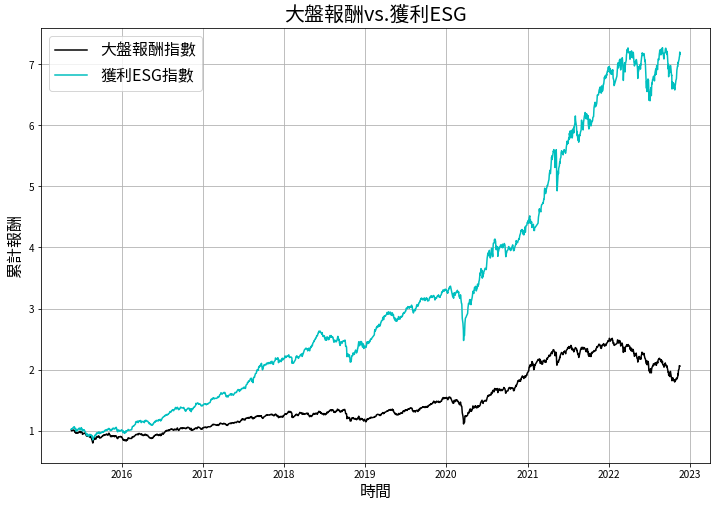

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

ax.plot(result['年月日'], result['997累計報酬'], label='大盤報酬指數', color='black')

ax.plot(result['年月日'], result['指數累計報酬'], label='獲利ESG指數', color='c')

ax.grid()

ax.legend(loc='best', fontsize=16)

plt.xlabel('時間', fontsize=16)
plt.ylabel('累計報酬', fontsize=16)

plt.title('大盤報酬vs.獲利ESG', fontsize=20)

plt.show()

In [22]:
def cul_std(df):
    return df.pct_change().std()*np.sqrt(252).round(3)

def cul_ret(df):
    return ((df.iloc[-1]**(1/len(df))-1)*252).round(3)

def mdd(df):
    return ((df / df.cummax()) - 1).cummin().iloc[-1].round(4)

In [53]:
stat = pd.DataFrame(index=['Y9997', '指數'],
                    columns=['年化標準差', '年化報酬率', '夏普值', 'MDD'],
                    data=[[cul_std(result['Y9997']), cul_ret(result['997累計報酬']), 0, mdd(result['997累計報酬'])],
                    [cul_std(result['指數']), cul_ret(result['指數累計報酬']), 0, mdd(result['指數累計報酬'])]])

stat['夏普值'] = stat['年化報酬率'] / stat['年化標準差']

stat['風暴比'] = 0
stat['風暴比'].iloc[0] = (result['997累計報酬'].iloc[-1]-1) / -stat['MDD'].iloc[0]
stat['風暴比'].iloc[1] = (result['指數累計報酬'].iloc[-1]-1) / -stat['MDD'].iloc[1]

In [24]:
result['997日報酬'] = result['Y9997'].pct_change()

result['指數日報酬'] = result['指數'].pct_change()



In [54]:
stat

,年化標準差,年化報酬率,夏普值,MDD,風暴比
Y9997,0.158997,0.099,0.622653,-0.2855,3.705562
指數,0.160755,0.271,1.685793,-0.2645,23.298591


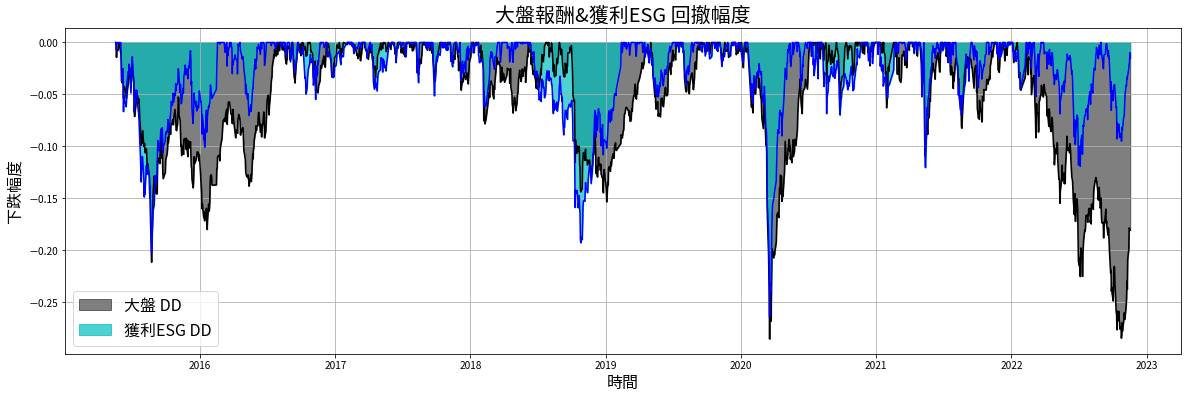

In [30]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

ax.plot(result['年月日'], result['997累計報酬'].to_drawdown_series().to_list(), color='black', linewidth=1.5)

ax.fill_between(result['年月日'], np.zeros(len(result['997累計報酬'])), result['997累計報酬'].to_drawdown_series().to_list(), label='大盤 DD', color='black', linewidth=1, alpha=0.5)

ax.plot(result['年月日'], result['指數累計報酬'].to_drawdown_series().to_list(), color='blue', linewidth=1.5)

ax.fill_between(result['年月日'], np.zeros(len(result['指數累計報酬'])), result['指數累計報酬'].to_drawdown_series().to_list(), label='獲利ESG DD', color='c', linewidth=1, alpha=0.7)

ax.grid()

ax.legend(loc='best', fontsize=16)

plt.xlabel('時間', fontsize=16)
plt.ylabel('下跌幅度', fontsize=16)

plt.title('大盤報酬&獲利ESG 回撤幅度', fontsize=20)

plt.show()

### 與878比較

In [31]:
df878 = tej.get('TWN/APRCD1', 
            coid=['00878'], 
            mdate={'gt': '2015-05-01', 'lt':'2022-12-01'}, 
            opts={'columns': ['coid', 'mdate', 'close_adj']},
            chinese_column_name=True, 
            paginate=True)

df878['年月日'] = df878['年月日'].astype('datetime64[ns]')

df878 = df878.pivot(columns='證券代碼', index='年月日', values='收盤價(元)').rename_axis(None, axis=1).reset_index()

result2 = df878.merge(result, left_on='年月日', right_on='年月日')

In [32]:
result2['997累計報酬'] = (result2['Y9997'].pct_change()+1).cumprod()
result2['指數累計報酬'] = (result2['指數'].pct_change()+1).cumprod()
result2['878累計報酬'] = (result2['00878'].pct_change()+1).cumprod()
result2

,年月日,00878,Y9997,指數,997累計報酬,指數累計報酬,997日報酬,指數日報酬,878累計報酬
0,2020-07-20,13.5271,23172.59,3874.117879,NaN,NaN,-0.000504,0.010020,NaN
1,2020-07-21,13.8980,23599.11,3913.344204,1.018406,1.010125,0.018406,0.010125,1.027419
2,2020-07-22,13.5183,23746.09,3953.038906,1.024749,1.020371,0.006228,0.010143,0.999349
3,2020-07-23,13.3682,23689.48,3996.224280,1.022306,1.031519,-0.002384,0.010925,0.988253
4,2020-07-24,13.2887,23489.96,3945.115686,1.013696,1.018326,-0.008422,-0.012789,0.982376
...,...,...,...,...,...,...,...,...,...
565,2022-11-14,16.4605,29418.21,7101.348392,1.269526,1.833023,0.011946,0.006587,1.216854
566,2022-11-15,16.4900,30189.11,7136.207657,1.302794,1.842021,0.026205,0.004909,1.219034
567,2022-11-16,16.4200,30170.51,7145.161068,1.301991,1.844332,-0.000616,0.001255,1.213860
568,2022-11-17,16.3700,30166.40,7216.243277,1.301814,1.862680,-0.000136,0.009948,1.210163


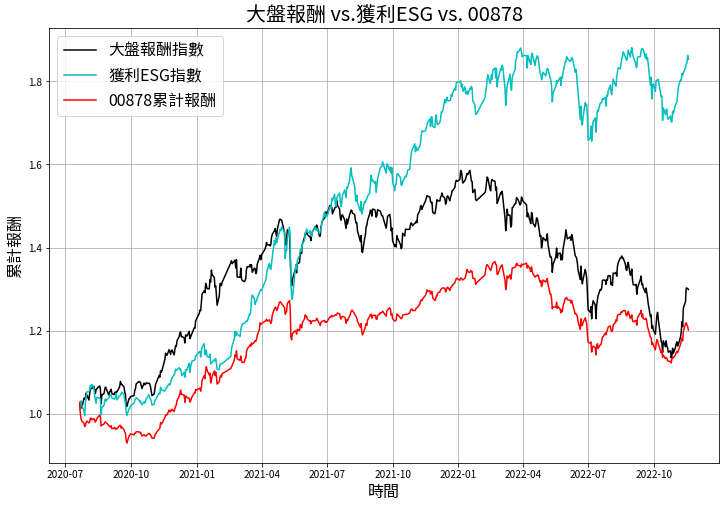

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

ax.plot(result2['年月日'], result2['997累計報酬'], label='大盤報酬指數', color='black')

ax.plot(result2['年月日'], result2['指數累計報酬'], label='獲利ESG指數', color='c')

ax.plot(result2['年月日'], result2['878累計報酬'], label='00878累計報酬', color='r')

ax.grid()

ax.legend(loc='best', fontsize=16)

plt.xlabel('時間', fontsize=16)
plt.ylabel('累計報酬', fontsize=16)

plt.title('大盤報酬 vs.獲利ESG vs. 00878', fontsize=20)

plt.show()

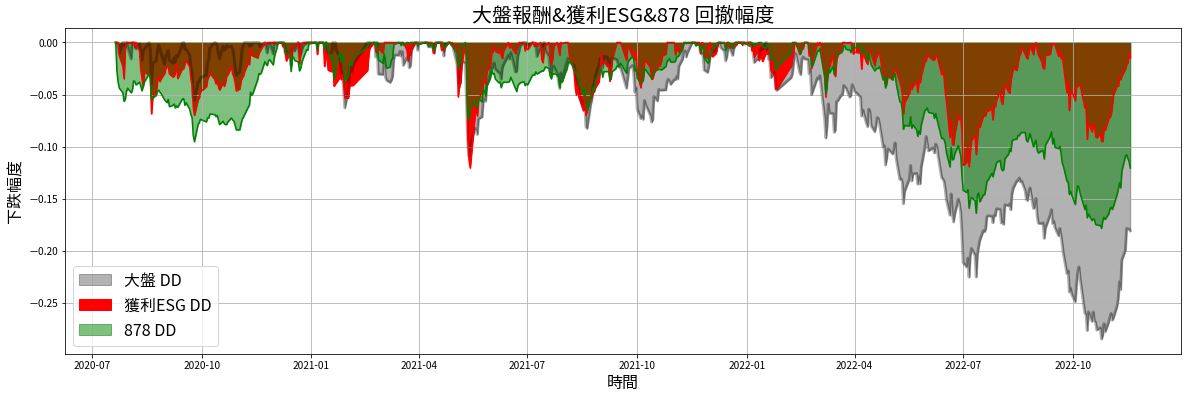

In [34]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

ax.plot(result2['年月日'], result2['997累計報酬'].to_drawdown_series().to_list(), color='black', linewidth=3, alpha=0.3)

ax.fill_between(result2['年月日'], np.zeros(len(result2['997累計報酬'])), result2['997累計報酬'].to_drawdown_series().to_list(), label='大盤 DD', color='black', linewidth=1, alpha=0.3)

ax.plot(result2['年月日'], result2['指數累計報酬'].to_drawdown_series().to_list(), color='r', linewidth=1.5)

ax.fill_between(result2['年月日'], np.zeros(len(result2['指數累計報酬'])), result2['指數累計報酬'].to_drawdown_series().to_list(), label='獲利ESG DD', color='r', linewidth=1, alpha=1)

ax.plot(result2['年月日'], result2['878累計報酬'].to_drawdown_series().to_list(), color='g', linewidth=1.5)

ax.fill_between(result2['年月日'], np.zeros(len(result2['878累計報酬'])), result2['878累計報酬'].to_drawdown_series().to_list(), label='878 DD', color='g', linewidth=1, alpha=0.5)

ax.grid()

ax.legend(loc='best', fontsize=16)

plt.xlabel('時間', fontsize=16)
plt.ylabel('下跌幅度', fontsize=16)

plt.title('大盤報酬&獲利ESG&878 回撤幅度', fontsize=20)

plt.show()

In [35]:
stat2 = pd.DataFrame(index=['00878', 'Y9997', '指數'],
                    columns=['年化標準差', '年化報酬率', '夏普值', 'MDD'],
                    data=[[cul_std(result2['00878']), cul_ret(result2['878累計報酬']), 0, mdd(result2['878累計報酬'])],
                    [cul_std(result2['Y9997']), cul_ret(result2['997累計報酬']), 0, mdd(result2['997累計報酬'])],
                    [cul_std(result2['指數']), cul_ret(result2['指數累計報酬']), 0, mdd(result2['指數累計報酬'])]])

stat2['夏普值'] = stat2['年化報酬率'] / stat2['年化標準差']

In [36]:
result2['878日報酬'] = result2['00878'].pct_change()
result2['997日報酬'] = result2['Y9997'].pct_change()
result2['指數日報酬'] = result2['指數'].pct_change()

In [37]:
result2[['997日報酬', '指數日報酬']].dropna().cov() / result2['997日報酬'].dropna().var()

,997日報酬,指數日報酬
997日報酬,1.000000,0.641569
指數日報酬,0.641569,0.900281


In [38]:
result2[['997日報酬', '878日報酬']].cov() / result2['997日報酬'].var()

,997日報酬,878日報酬
997日報酬,1.000000,0.554336
878日報酬,0.554336,0.461233


In [39]:
stat2['風暴比'] = 0
stat2['風暴比'].iloc[0] = (result2['878累計報酬'].iloc[-1]-1) / -stat2['MDD'].iloc[0]
stat2['風暴比'].iloc[1] = (result2['997累計報酬'].iloc[-1]-1) / -stat2['MDD'].iloc[1]
stat2['風暴比'].iloc[2] = (result2['指數累計報酬'].iloc[-1]-1) / -stat2['MDD'].iloc[2]

In [40]:
model1 = LinearRegression().fit(result2[['997日報酬']].dropna(), result2[['指數日報酬']].dropna())
model2 = LinearRegression().fit(result2[['997日報酬']].dropna(), result2[['878日報酬']].dropna())

print(f'指數Beta值: {model1.coef_[0][0]:8.3f}')
print(f'878Beta值:  {model2.coef_[0][0]:8.3f}')

指數Beta值:    0.642
878Beta值:     0.554


In [41]:
stat2

,年化標準差,年化報酬率,夏普值,MDD,風暴比
00878,0.120600,0.081,0.671644,-0.1784,1.128320
Y9997,0.177577,0.116,0.653239,-0.2847,1.050596
指數,0.168490,0.273,1.620271,-0.1205,7.077966


### 圖表統計

In [42]:
price_nd = price.pivot(columns='公司', index='年月', values='收盤價(元)')
#取出所有週期
period = div_30_Sem['年月'].drop_duplicates().to_list()
#取出所有公司
company = [list(div_30_Sem.groupby('年月'))[i][1]['公司'].to_list() for i in range(len(list(div_30_Sem.groupby(['年月']))))]
#取出所有權重分配
weights = [list(div_30_Sem.groupby('年月'))[i][1]['權重分配'].to_list() for i in range(len(list(div_30_Sem.groupby(['年月']))))]

period_ret = []
for i in range(1, len(weights)):
    div_30_Sem.loc[div_30_Sem['年月'].isin([period[i-1]]), ['到期報酬']] = (((price_nd.loc[period[i-1] : period[i], company[i-1]].pct_change()+1).cumprod().iloc[-1]-1)*100).to_list()

div_30_Sem.loc[div_30_Sem['年月'].isin([period[-1]]), ['到期報酬']] = (((price_nd.loc[period[-1] : pd.Timestamp(2022,11,18), company[-1]].pct_change()+1).cumprod().iloc[-1]-1)*100).to_list()

div_30_Sem['到期報酬'] = div_30_Sem['到期報酬'].round(2)

In [43]:
par_label = []
target = div_30_Sem.tail(20).sort_values('權重分配', ascending=False).head(10)[['代碼', '到期報酬']]
for i in range(len(target)):
    par_label.append(target.iloc[i][0]+' '+ target.iloc[i][1].astype(str)+'%')

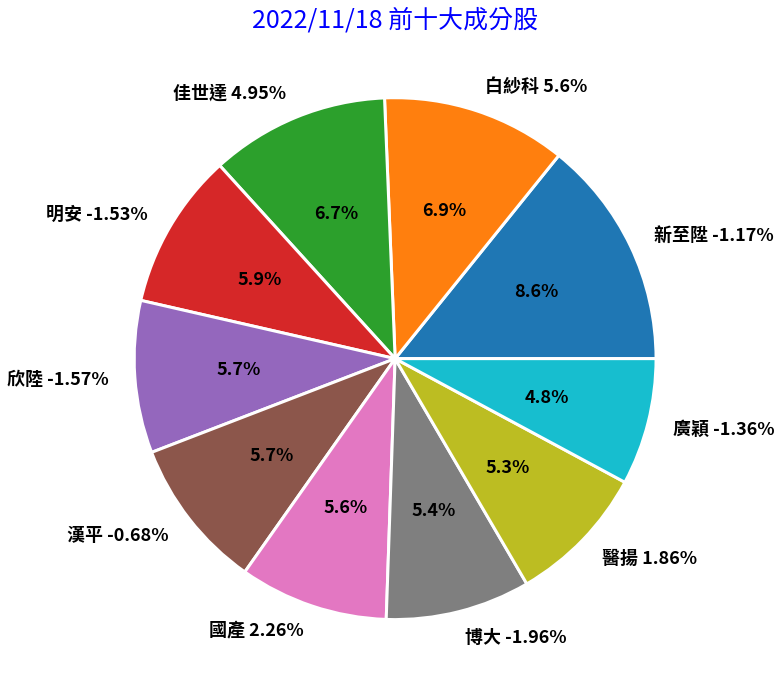

In [44]:
plt.figure(figsize=(12,12)) 

def fun(i, x):
        return f'{i * x.sum():1.1f}%'

def label_color(i, x):
        return f'{x[i]}'

x = div_30_Sem.tail(20)['權重分配'].nlargest(10)

plt.pie(x,                           # 數值
        labels = par_label,                # 標籤
        autopct = lambda i:fun(i, x),            # 取得原本前十大所占比例,呈現小數點後一位
        #explode = separeted,            # 設定分隔的區塊位置
        pctdistance = 0.6,              # 數字距圓心的距離
        textprops = {'color':'black', 'weight':'bold', 'size':18},  # 文字大小
        #shadow=True,
        wedgeprops={'linewidth':3,'edgecolor':'w'})                    

 
#plt.axis('equal')                                          # 使圓餅圖比例相等
plt.title("2022/11/18 前十大成分股", fontsize=25, color='b')  # 設定標題及其文字大小
#plt.legend(loc = "best")   
plt.show()

In [45]:
div_30_Sem.tail(20).sort_values('到期報酬')

,年月,公司,代碼,淨利CAGR_3,產業ROE中位數,ROE(A)－稅後,市值(百萬元),股利殖利率-TSE,年,TESG等級,近三年股利殖利率,TSE新產業名,股利分數,權重分配,到期報酬
607,2022-11-14,8109,博大,0.237357,4.205,12.10,6816.0,4.60,2022,B,5.405833,M2328 電子零組件,5.244667,0.054367,-1.96
604,2022-11-14,3703,欣陸,0.209770,1.410,1.42,23585.0,5.86,2022,A,5.433333,M2500 建材營造,5.518667,0.057208,-1.57
603,2022-11-14,8938,明安,0.242124,4.110,10.67,13234.0,5.62,2022,A+,5.675000,M9900 其他,5.664000,0.058714,-1.53
609,2022-11-14,4973,廣穎,0.913849,4.490,7.53,1397.0,4.55,2022,B-,4.608333,M2324 半導體,4.596667,0.047650,-1.36
611,2022-11-14,8420,明揚,0.201941,4.110,12.31,3646.0,3.50,2022,B+,4.253333,M9900 其他,4.102667,0.042529,-1.26
618,2022-11-14,5288,豐祥,0.221021,4.030,6.47,11028.0,2.69,2022,A,3.820833,M1500 電機機械,3.594667,0.037263,-1.19
600,2022-11-14,3679,新至陞,0.246332,4.205,7.73,5908.0,9.61,2022,B,7.986667,M2328 電子零組件,8.311333,0.086157,-1.17
605,2022-11-14,2488,漢平,0.388499,4.770,6.49,2340.0,4.10,2022,B,5.835833,M2331 其他電子業,5.488667,0.056897,-0.68
615,2022-11-14,4538,大詠城,0.232911,4.030,4.03,1009.0,2.50,2022,B,3.990000,M1500 電機機械,3.692000,0.038272,0.00
613,2022-11-14,9802,鈺齊,0.394947,4.110,11.25,28315.0,2.80,2022,B,4.094167,M9900 其他,3.835333,0.039758,0.34


In [46]:
sum(div_30_Sem.iloc[-20:, -1] * div_30_Sem.iloc[-20:, -2])

1.0855460570417619

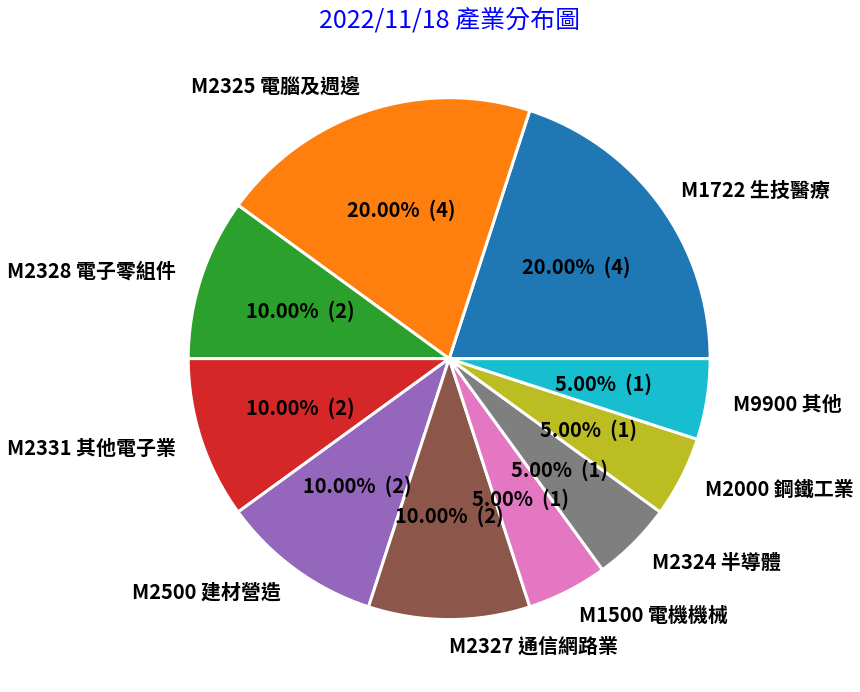

In [47]:
#仿造指數前十大成分股圓餅圖
plt.figure(figsize=(12,12)) 

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

x = div_30_Sem.tail(20)['TSE新產業名'].value_counts()

plt.pie(x,                           # 數值
        labels = div_30_Sem.tail(20)['TSE新產業名'].unique(),                # 標籤
        autopct = make_autopct(x),            
        #explode = separeted,            # 設定分隔的區塊位置
        pctdistance = 0.6,               # 數字距圓心的距離
        textprops = {'color':'black', 'weight':'bold', 'size':20},  # 文字大小
        #shadow=True,
        wedgeprops={'linewidth':3,'edgecolor':'w'})                    

 
#plt.axis('equal')                                           # 使圓餅圖比例相等
plt.title("2022/11/18 產業分布圖", fontsize=25, color='b')  # 設定標題及其文字大小
#plt.legend(loc = "upper right")   
plt.show()

### 週期統計(柱狀圖)

In [48]:
index_m = pd.DataFrame(result.set_index('年月日')['指數累計報酬'].resample('BM').last())

index_m = index_m.drop(index='2022-11-30')

index_m = index_m.reset_index().append({'年月日':pd.Timestamp(2015,5,15), '指數累計報酬':1.0}, ignore_index=True).set_index('年月日').sort_index()

index_m = index_m.reset_index().append({'年月日':pd.Timestamp(2022,11,18), '指數累計報酬':df.iloc[-1]['指數']/1000}, ignore_index=True).set_index('年月日').sort_index()

index_m['單月報酬'] = index_m['指數累計報酬'].pct_change()*100

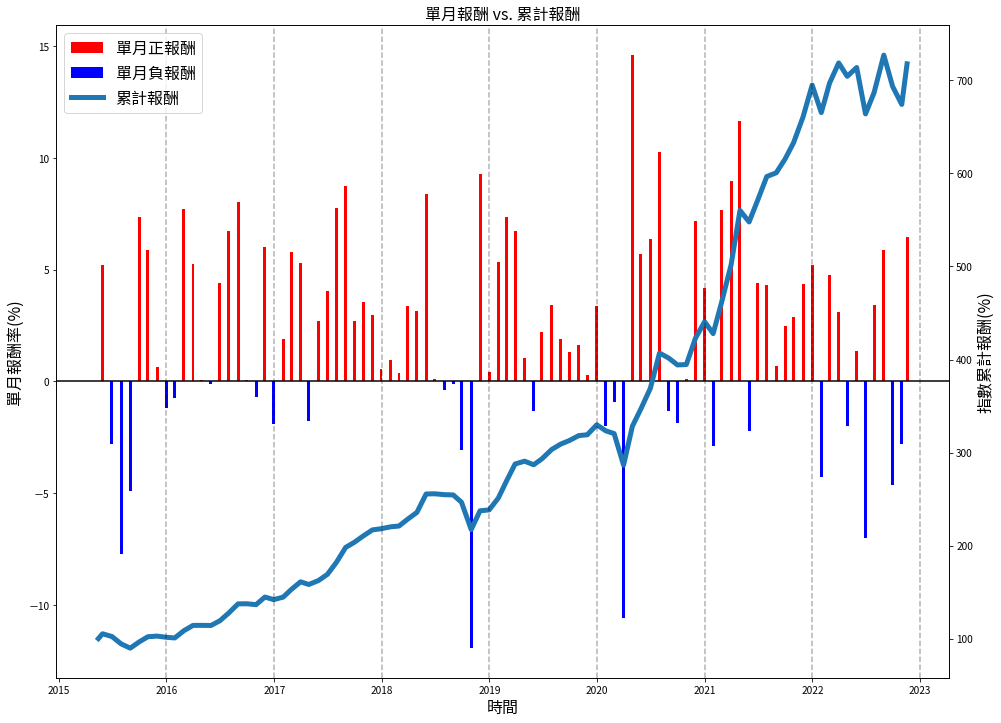

In [49]:
fig = plt.figure(figsize=(16, 12))

ax = fig.subplots()

ax2 = ax.twinx()

ax.bar(index_m.index, [i if i >= 0 else 0 for i in index_m['單月報酬']], color='red', width=10, label='單月正報酬')

ax.bar(index_m.index, [i if i < 0 else 0 for i in index_m['單月報酬']], color='blue', width=10, label='單月負報酬')

ax2.plot(index_m.index, index_m['指數累計報酬']*100, label='累計報酬', linewidth=5)

ax.axhline(y = 0, color='black')

for i in range(2015, 2023):
    plt.axvline(x = [pd.Timestamp(i,12,31)], color='black', linestyle="--", alpha=0.3)

ax.set_xlabel('時間', fontsize=16)

ax.set_ylabel('單月報酬率(%)', fontsize=16)

ax2.set_ylabel('指數累計報酬(%)', fontsize=16)

plt.title('單月報酬 vs. 累計報酬', fontsize=16)

fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes, fontsize=16)